In [23]:
import matplotlib.pyplot as plt
#%matplotlib widget
from ipywidgets import *
import numpy as np
import sys

In [24]:
import taurex.log
taurex.log.disableLogging()
from taurex.cache import OpacityCache,CIACache

path_to_data = ''
OpacityCache().clear_cache()
OpacityCache().set_opacity_path(f"../atmosphere/xsecs")
CIACache().set_cia_path(f"../atmosphere/cia/hitran")

from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1415.0)

from taurex.planet import Planet
planet = Planet(planet_radius=1.39,planet_mass=0.58)

from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=6230.0,radius=1.28)

from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

from taurex.chemistry import ConstantGas
H2O=10**np.random.uniform(-2,-8)
CH4=10**np.random.uniform(-2,-8)
CO2=10**np.random.uniform(-2,-8)
CO=10**np.random.uniform(-2,-8)

chemistry.addGas(ConstantGas('H2O',mix_ratio=H2O))
chemistry.addGas(ConstantGas('CH4',mix_ratio=CH4))
chemistry.addGas(ConstantGas('CO2',mix_ratio=CO2))
chemistry.addGas(ConstantGas('CO',mix_ratio=CO))

In [25]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

from taurex.contributions import CIAContribution
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))

from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

tm.build()
res = tm.model()

from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()

#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

<Figure size 640x480 with 0 Axes>

In [26]:
# we take the data of our simulated spectrum taking as error the square root of (Rp/Rs)^2 (Poisson error)
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum(f'WASP_62b_assignment3_taskA_spectrum.dat')

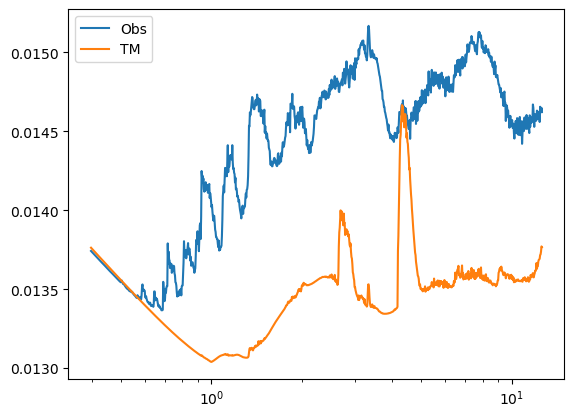

In [27]:
# now we make a binning and plot the spectrum:
obin = obs.create_binner()
plt.figure()
plt.plot(obs.wavelengthGrid,obs.spectrum,label='Obs')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
plt.xscale('log')
plt.legend()
plt.show()